In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Thesis_work/ML_experiments'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/16LLv0tl9NuELAOpNIA0EW8v8njV1fcVa/Thesis_work/ML_experiments


#Loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
#!pip install xgboost
from xgboost import XGBClassifier
# !pip install catboost
# from catboost import CatBoostRegressor
import sklearn
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

#Method for confusion matrix plot

In [3]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(Y, predicted):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(Y, Y_predicted_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(Y, Y_predicted_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(Y, Y_predicted_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(Y, Y_predicted_classes)
  print('F1 score: %f' % f1)
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#Load the dataset


In [4]:
data = pd.read_csv('final_dataset_reviews_clean.csv')
# data.drop(columns=['Unnamed: 0'], inplace = True)
data.head(2)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,TE111EL1,itzmr7,6702,2019-11-09,1,0,mil gya hai acha hai aur toota howa b nai hai,Positive,['toota'],45,...,0.051918,0,1,-2.000000,-2.000000,acha tota howa nahi,1.0,19,4,539
1,MI543EL0,Afridi,396,2016-11-21,5,0,aram sy pocket may aa jta hai aur quality b ac...,Positive,"['aram', 'pocket', 'quality']",52,...,0.035987,1,1,0.466667,0.466667,aram pocket jta quality achi,1.0,28,5,336


#TRain and test data

In [5]:
spam_true = data[data['Label']==1]
spam_true=sklearn.utils.shuffle(spam_true, random_state=10)
print(spam_true.shape)
test_true = spam_true[:100]
train_true=spam_true[100:]
spam_false = data[data['Label']==0]
print(spam_false.shape)
spam_false=sklearn.utils.shuffle(spam_false, random_state=10)
test_false = spam_false[:100]
train_false=spam_false[100:]
train_data = pd.concat([train_true,train_false], ignore_index=True, sort=False)
train_data.to_csv('Spam_clean_train'+'.csv', index=False)
test_data = pd.concat([test_true,test_false],ignore_index=True, sort=False)
test_data.to_csv('Spam_clean_test'+'.csv', index=False)

(530, 23)
(3393, 23)


In [6]:
df_train=pd.read_csv('Spam_clean_train.csv');
df_test=pd.read_csv('Spam_clean_test.csv');

In [7]:
df_train.head(2)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,VI363HL1,Nasir Arafat Anwar,3953,2017-07-03,5,1,meri wife isse cooking mein istemaal kar rahi ...,Positive,['wife'],73,...,0.043131,1,0,2.250000,2.250000,meri wife coking istemal bohat kam araha,1.0,40,7,589
1,UB622ME1,Hamza,2020,2016-11-14,5,1,bilkul seal pack haalat mein mila aur mein iss...,Negative,"['seal', 'pack', 'haalat', 'masnoaat', 'khush']",71,...,0.053663,1,0,0.098039,0.333333,bilkul seal pack halat mila masnoat khush,0.0,41,7,574


##Features and label

In [8]:
X_train=df_train.drop(columns=[ 'Sentiment_class', 'Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
X_test=df_test.drop(columns=['Sentiment_class', 'Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
y_train=df_train['Label']
y_test=df_test['Label']


#Resampling Technique RUS(Under sampling)

In [9]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
# rus = RandomUnderSampler(random_state=42, sampling_strategy=0.8)
X_train_ru, y_train_ru = rus.fit_resample(X_train, y_train)

In [10]:
X_train_ru.shape

(860, 14)

In [11]:
X_test.shape

(200, 14)

#Basic Classification Models

##XGBoost

Accuracy: 0.770000
Precision: 0.759615
Recall: 0.790000
F1 score: 0.774510
(2, 2)
(2, 2)


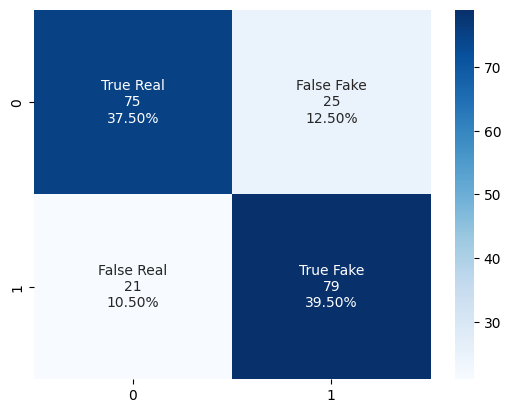

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# fit model training data
model = XGBClassifier()

model.fit(X_train_ru, y_train_ru)

#---Without feature selection and parameter tuning------
pred_xg = model.predict(X_test)
# evaluate predictions
plot_confusion_matrix(y_test,pred_xg)


##**Gradient Boosting**

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       100
           1       0.75      0.80      0.78       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Accuracy: 0.770000
Precision: 0.754717
Recall: 0.800000
F1 score: 0.776699
(2, 2)
(2, 2)


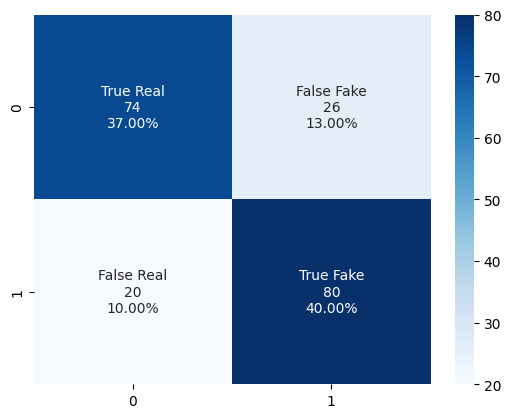

In [13]:
model_gb = GradientBoostingClassifier()

#-------- Without Feature selection---------
model_gb.fit(X_train_ru,y_train_ru)
pred_gb = model_gb.predict(X_test)
print(classification_report(y_test, pred_gb))

#-----evaluate results-----
plot_confusion_matrix(y_test,pred_gb)


##Light GBM

[LightGBM] [Info] Number of positive: 430, number of negative: 430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1657
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.800000
Precision: 0.767857
Recall: 0.860000
F1 score: 0.811321
(2, 2)
(2, 2)


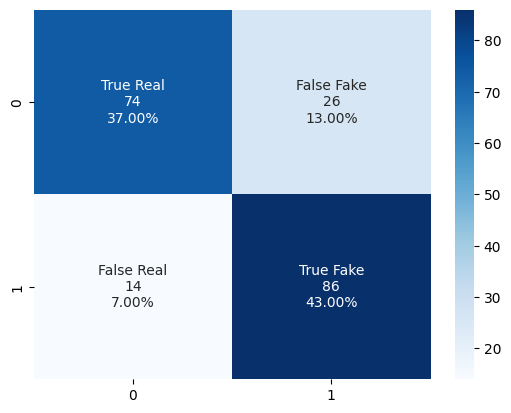

In [14]:
model_lg = lgb.LGBMClassifier()
model_lg.fit(X_train_ru, y_train_ru)
pred_lg = model_lg.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_lg)

##Decision Tree

Accuracy: 0.625000
Precision: 0.621359
Recall: 0.640000
F1 score: 0.630542
(2, 2)
(2, 2)


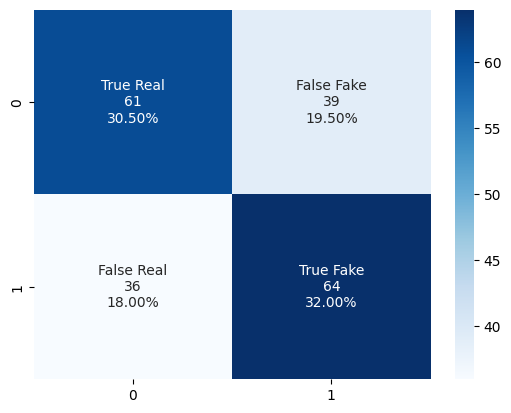

In [15]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_ru, y_train_ru)
pred_dt = model_dt.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_dt)

##Naive bayes

Accuracy: 0.545000
Precision: 0.549451
Recall: 0.500000
F1 score: 0.523560
(2, 2)
(2, 2)


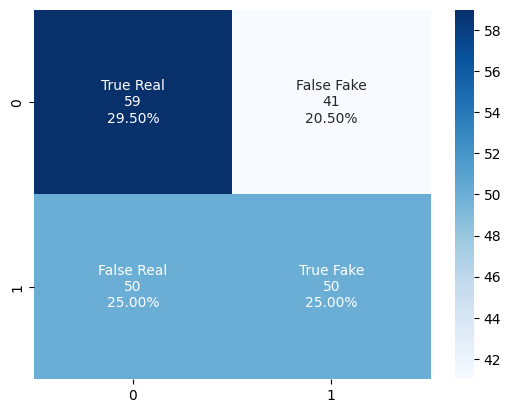

In [16]:
#Bernoulli Navie Bayes Classifier
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train_ru, y_train_ru)
pred_nb = BNB_Classifier.predict(X_test)
# print("\nClassification report for BernoulliNB Classifier %s:\n%s\n" % (BNB_Classifier, metrics.classification_report(y_test, pred_nb)))
plot_confusion_matrix(y_test,pred_nb)


Accuracy: 0.625000
Precision: 0.727273
Recall: 0.400000
F1 score: 0.516129
(2, 2)
(2, 2)


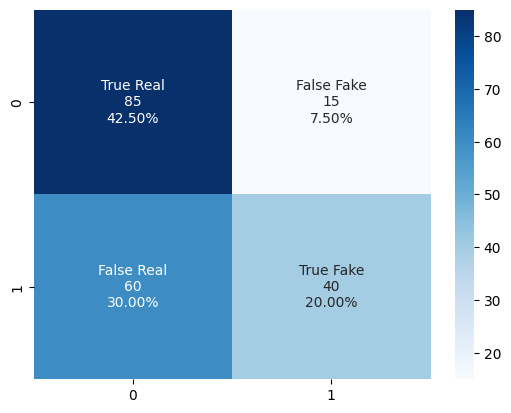

In [17]:
#Bernoulli Navie Bayes Classifier
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train_ru, y_train_ru)
GNB_Predictions =  GNB_Classifier.predict(X_test)
plot_confusion_matrix(y_test,GNB_Predictions)

##Logistic REgression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.590000
Precision: 0.600000
Recall: 0.540000
F1 score: 0.568421
(2, 2)
(2, 2)


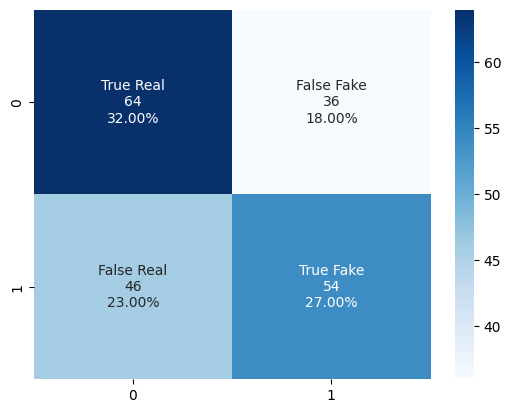

In [18]:
LR_Classifier = LogisticRegression()
LR_Classifier.fit(X_train_ru, y_train_ru)
pred_lr = LR_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_lr)

##Support VEctor

Accuracy: 0.525000
Precision: 0.526882
Recall: 0.490000
F1 score: 0.507772
(2, 2)
(2, 2)


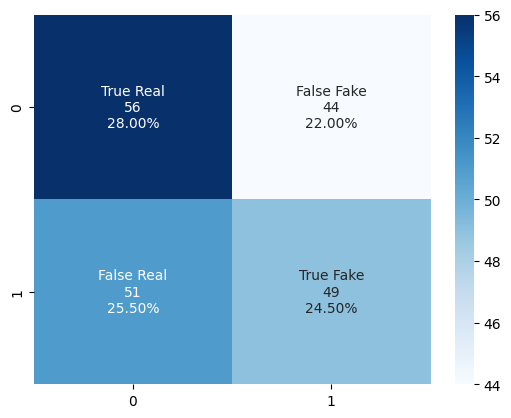

In [19]:
#SVC Classifier
SVC_Classifier = SVC()
SVC_Classifier.fit(X_train_ru, y_train_ru)
pred_svc = SVC_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_svc)

##**Random Forest Classifier**

accuracy 0.715
Accuracy: 0.715000
Precision: 0.717172
Recall: 0.710000
F1 score: 0.713568
(2, 2)
(2, 2)


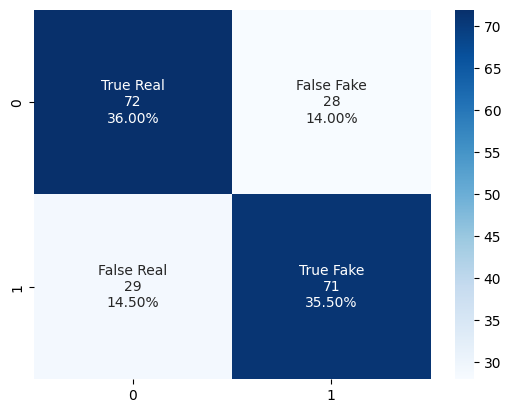

In [20]:

model_rf = RandomForestClassifier(n_estimators=110)
model_rf.fit(X_train_ru,y_train_ru)
pred_rf = model_rf.predict(X_test)
print('accuracy %s' % accuracy_score(pred_rf, y_test))
#print(classification_report(y_test, pred_rf))
plot_confusion_matrix(y_test,pred_rf)

##**Stochastic Gradient Descent**

Accuracy: 0.495000
Precision: 0.333333
Recall: 0.010000
F1 score: 0.019417
(2, 2)
(2, 2)


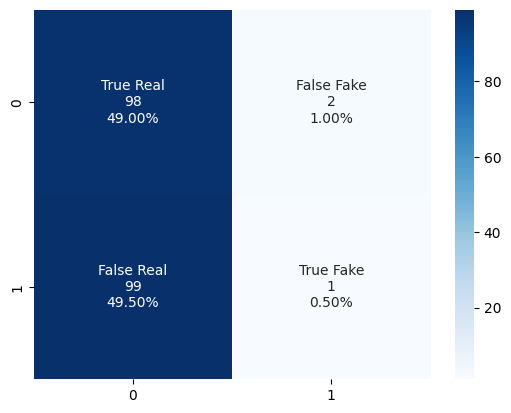

In [21]:

model_sg = SGDClassifier()
model_sg.fit(X_train_ru,y_train_ru)
pred_sg = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_sg)

##ANN

In [22]:
X_train_ru.shape[1]

14

In [23]:
from keras import models
from keras import layers
dnn = models.Sequential()
dnn.add(layers.Dense(16, activation = 'relu', input_shape=(X_train_ru.shape[1],)))
dnn.add(layers.Dropout(0.3))
dnn.add(layers.Dense(8, activation = 'relu', input_shape=(X_train_ru.shape[1],)))

dnn.add(layers.Dense(1, activation = 'sigmoid'))

dnn.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = dnn.fit(X_train_ru,
                  y_train_ru,
                    batch_size=40)

dnn.evaluate(X_test,y_test)

7/7 [==============================] - 0s 9ms/step - loss: 6.3566 - accuracy: 0.5450


[6.356635093688965, 0.5450000166893005]

Accuracy: 0.495000
Precision: 0.333333
Recall: 0.010000
F1 score: 0.019417
(2, 2)
(2, 2)


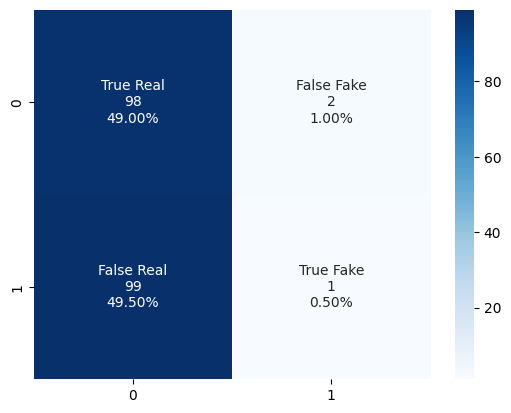

In [24]:
pred_ann = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_ann)

#**Best model Accuracy and F-score**

We tested six different models and now, we check which one is the best:

In [25]:
xg_acc = accuracy_score(pred_xg, y_test)
gb_acc = accuracy_score(pred_gb, y_test)
nb_acc = accuracy_score(pred_nb, y_test)
rf_acc = accuracy_score(pred_rf, y_test)
sg_acc = accuracy_score(pred_sg, y_test)
svm_acc = accuracy_score(pred_svc, y_test)
lr_acc = accuracy_score(pred_lr, y_test)
dt_acc = accuracy_score(pred_dt, y_test)
ann_acc = accuracy_score(pred_ann, y_test)
lgb_acc = accuracy_score(pred_lg,y_test)

xg_f1 = f1_score(pred_xg, y_test)
gb_f1 = f1_score(pred_gb, y_test)
nb_f1 = f1_score(pred_nb, y_test)
rf_f1 = f1_score(pred_rf, y_test)
sg_f1 = f1_score(pred_sg, y_test)
svm_f1 = f1_score(pred_svc, y_test)
lr_f1 = f1_score(pred_lr, y_test)
dt_f1 = f1_score(pred_dt, y_test)
ann_f1 = f1_score(pred_ann, y_test)
lgb_f1 = f1_score(pred_lg,y_test)

In [26]:
models = pd.DataFrame({
                      'Model': ['Extreme Gradient','Light GBM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD', 'Logistic Regression', 'Decision Tree', 'ANN'],
                      'Accuracy': [xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc],
                      'F-Score': [xg_f1, lgb_f1, nb_f1, rf_f1, gb_f1, svm_f1, sg_f1, lr_f1, dt_f1, ann_f1]
                       })
models.sort_values(by='F-Score', ascending=False, inplace=True)
models

,Model,Accuracy,F-Score
1,Light GBM,0.800,0.811321
4,Gradient Boosting,0.770,0.776699
0,Extreme Gradient,0.770,0.774510
3,Random Forest,0.715,0.713568
8,Decision Tree,0.625,0.630542
7,Logistic Regression,0.590,0.568421
2,Naive Bayes,0.545,0.523560
5,SVM,0.525,0.507772
6,SGD,0.495,0.019417
9,ANN,0.495,0.019417


##Save Result

In [27]:
models.to_csv("paper/expsettingIV_RUS_80.csv", index=False)

#Grouped confusion matrix

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


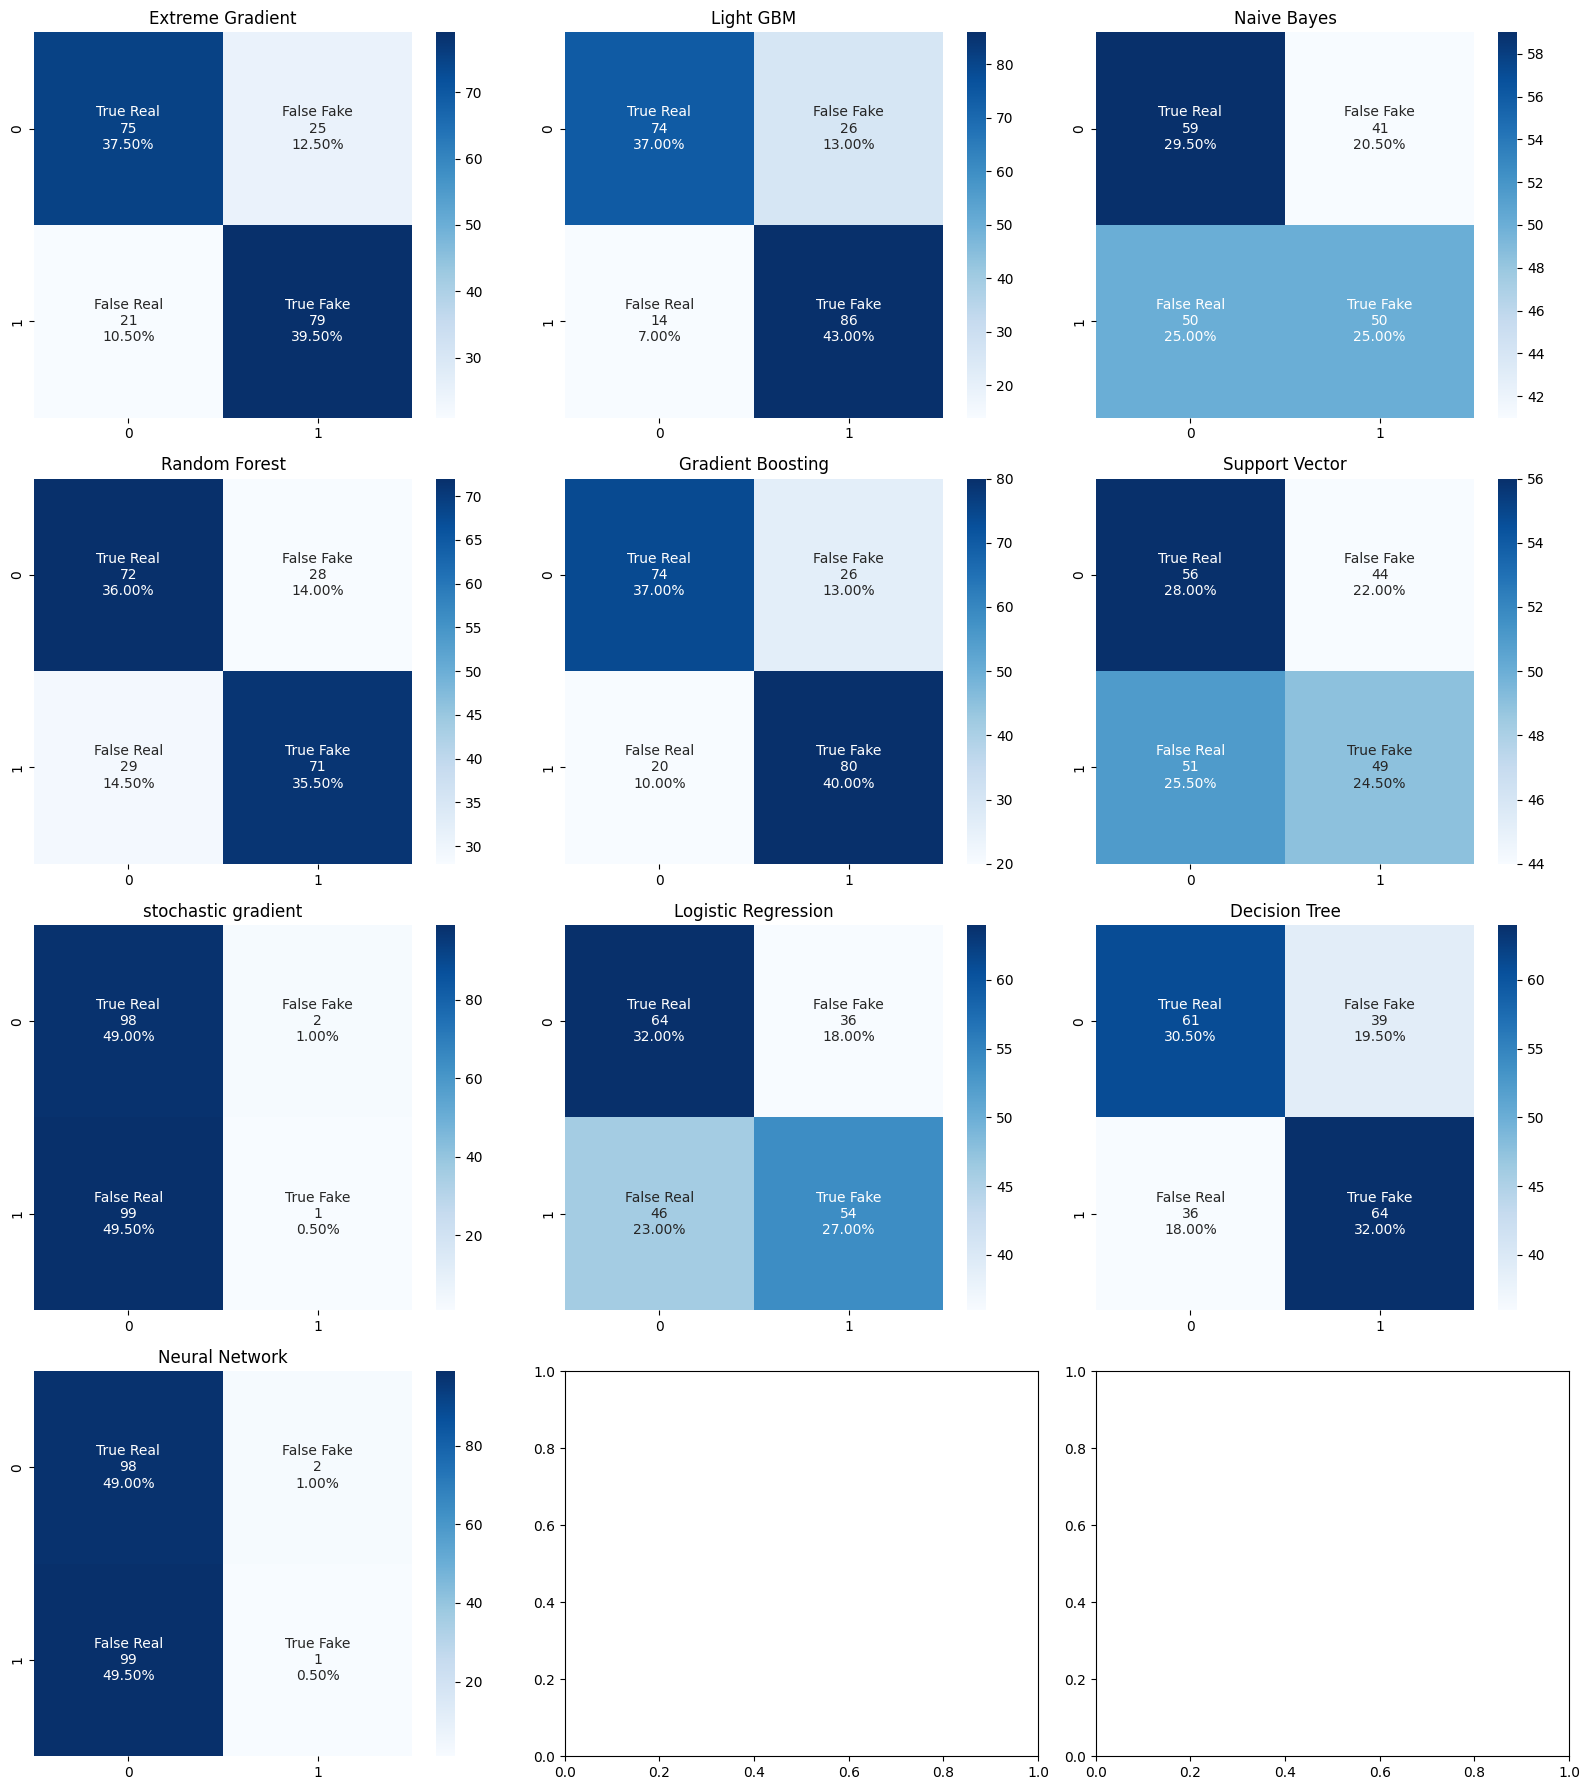

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
fig, axes = plt.subplots(4, 3, figsize=(16, 18))

def plot_grouped_cm(Y, predicted, r,c, model):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax =axes[r,c])
  axes[r,c].set_title(model)
xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc
plot_grouped_cm(y_test, pred_xg, 0,0, 'Extreme Gradient')
plot_grouped_cm(y_test, pred_lg, 0,1, 'Light GBM')
plot_grouped_cm(y_test, pred_nb, 0,2, 'Naive Bayes')
plot_grouped_cm(y_test, pred_rf, 1,0, 'Random Forest')
plot_grouped_cm(y_test, pred_gb, 1,1, 'Gradient Boosting')

plot_grouped_cm(y_test, pred_svc, 1,2, 'Support Vector')
plot_grouped_cm(y_test, pred_sg, 2,0, 'stochastic gradient')
plot_grouped_cm(y_test, pred_lr, 2,1, 'Logistic Regression')
plot_grouped_cm(y_test, pred_dt, 2,2, 'Decision Tree')
plot_grouped_cm(y_test, pred_ann, 3,0, 'Neural Network')



fig.tight_layout()
fig.savefig("paper/expsettingIV_RUS_80.png")